In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 10
split_ratio_calib = 0.8

max_workers = 32

data_dir = "data/adult"

In [2]:
## Load UCI Adult dataset

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_adult(data_dir)
inputs_u_df = loader.load_adult(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,Female,Male
Target,,
<=50K,14423,22732
>50K,1769,9918


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.5785373341293101


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

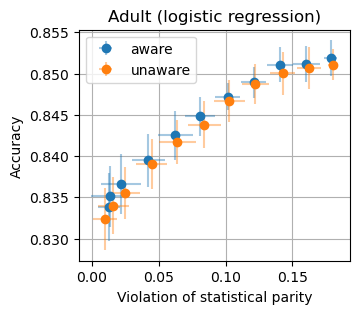

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.178678  0.004754
0.160  0.851201  0.002173  0.160333  0.009995
0.140  0.851051  0.002117  0.140767  0.009515
0.120  0.848922  0.001868  0.121103  0.009423
0.100  0.847161  0.001632  0.101662  0.009496
0.080  0.844813  0.002326  0.081012  0.011170
0.060  0.842506  0.002938  0.062412  0.012931
0.040  0.839489  0.003197  0.042196  0.012257
0.020  0.836623  0.003687  0.021739  0.014722
0.010  0.835108  0.003695  0.013742  0.013935
0.001  0.833784  0.004118  0.013178  0.008252

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.180177  0.003911
0.160  0.850628  0.002536  0.162415  0.009150
0.140  0.850055  0.002608  0.142830  0.009367
0.120  0.848758  0.002400  0.122294  0.010276
0.100  0.846615  0.002543  0.102838  0.011561
0.080  0.843817  0.002839  0.084089  0.012375
0.060  0.841714  0.002652  0.063881  0.013717
0.040  0.839039  0.002989  0.044775  0.011652
0.020  0.835504  0.003154  0.024772  0.011449
0.010  0.833989  0.003432  0.016087  0.011614
0.001  0.832391  0.003800  0.009823  0.008913

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

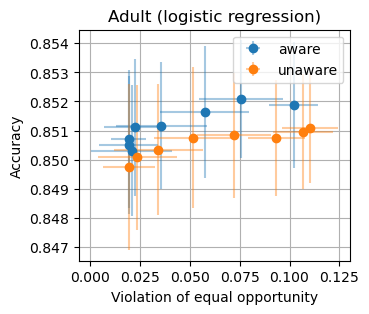

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851870  0.002166   0.101989  0.012120
0.100  0.852075  0.002032   0.075608  0.020899
0.080  0.851638  0.002262   0.057342  0.022201
0.060  0.851174  0.002200   0.035635  0.022835
0.040  0.851119  0.002356   0.022422  0.015420
0.020  0.850696  0.002372   0.019212  0.008892
0.010  0.850505  0.002384   0.019300  0.014899
0.001  0.850314  0.002246   0.020774  0.020191

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851078  0.001892   0.110289  0.014067
0.100  0.850956  0.001975   0.106763  0.015044
0.080  0.850737  0.002003   0.093319  0.014245
0.060  0.850846  0.002150   0.072079  0.018759
0.040  0.850751  0.002418   0.051685  0.019562
0.020  0.850341  0.002255   0.034034  0.022282
0.010  0.850082  0.002497   0.023621  0.019728
0.001  0.849741  0.002855   0.019391  0.013272

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

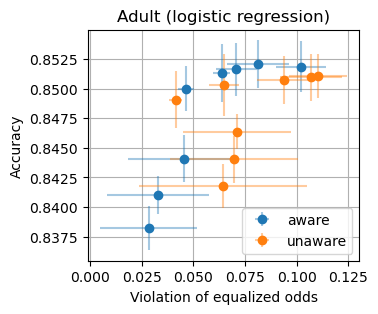

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.101989  0.012120
0.100  0.852075  0.002032  0.081294  0.014834
0.080  0.851638  0.002262  0.070771  0.009929
0.060  0.851351  0.002462  0.063690  0.004098
0.040  0.850000  0.001889  0.046551  0.004003
0.020  0.844103  0.001946  0.045315  0.026997
0.010  0.841032  0.001604  0.032989  0.024644
0.001  0.838206  0.001861  0.028472  0.023453

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.110289  0.014067
0.100  0.850956  0.001975  0.106763  0.015044
0.080  0.850737  0.002003  0.093916  0.013040
0.060  0.850287  0.002623  0.064747  0.007311
0.040  0.849085  0.002378  0.041436  0.003117
0.020  0.846355  0.001474  0.071108  0.026289
0.010  0.844021  0.001968  0.069838  0.031014
0.001  0.841769  0.001846  0.064232  0.040742

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

[LightGBM] [Info] Number of positive: 4080, number of negative: 13015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 17095, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238666 -> initscore=-1.160006
[LightGBM] [Info] Start training from score -1.160006
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 17095, number of used features: 81
[LightGBM] [Info] Start training from score -1.208174
[LightGBM] [Info] Start training from 

Calibration error of attribute-blind predictor: 0.5665340622360996


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

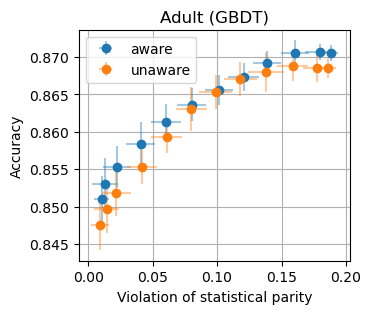

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.188283  0.005546
0.180  0.870680  0.001119  0.179737  0.011426
0.160  0.870571  0.001671  0.160559  0.010637
0.140  0.869206  0.001539  0.138895  0.010806
0.120  0.867349  0.001825  0.120649  0.012092
0.100  0.865602  0.002038  0.101343  0.010911
0.080  0.863650  0.002212  0.080166  0.011092
0.060  0.861302  0.002393  0.060123  0.011544
0.040  0.858327  0.003065  0.040732  0.011081
0.020  0.855337  0.002766  0.022369  0.011047
0.010  0.853003  0.003573  0.012977  0.010194
0.001  0.850996  0.003137  0.010325  0.005502

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.186011  0.005891
0.180  0.868482  0.001756  0.177621  0.011380
0.160  0.868741  0.001998  0.158669  0.011989
0.140  0.867977  0.002584  0.138017  0.013748
0.120  0.867035  0.002282  0.118060  0.012665
0.100  0.865315  0.002248  0.098820  0.012691
0.080  0.863049  0.002933  0.080065  0.012307
0.060  0.859337  0.002196  0.060813  0.011813
0.040  0.855364  0.002252  0.041569  0.011536
0.020  0.851802  0.003040  0.021879  0.011091
0.010  0.849700  0.003258  0.014438  0.009559
0.001  0.847570  0.003362  0.009398  0.006846

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

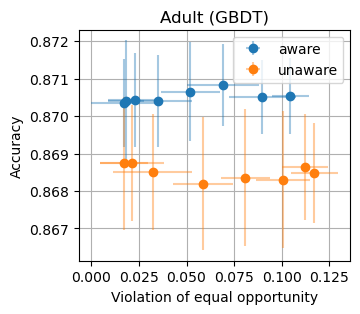

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.870530  0.001009   0.104615  0.009519
0.100  0.870502  0.000984   0.089898  0.017433
0.080  0.870830  0.001105   0.069172  0.018765
0.060  0.870652  0.001319   0.052068  0.015627
0.040  0.870393  0.001228   0.034801  0.018176
0.020  0.870352  0.001177   0.017048  0.017009
0.010  0.870407  0.001618   0.018221  0.009491
0.001  0.870420  0.001251   0.022665  0.013958

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.868482  0.001342   0.117159  0.012465
0.100  0.868646  0.001411   0.112457  0.012107
0.080  0.868305  0.001823   0.100711  0.014380
0.060  0.868359  0.001817   0.080870  0.012869
0.040  0.868195  0.001777   0.058621  0.015974
0.020  0.868509  0.001546   0.032162  0.020941
0.010  0.868741  0.001547   0.021122  0.016821
0.001  0.868741  0.001771   0.016954  0.012524

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

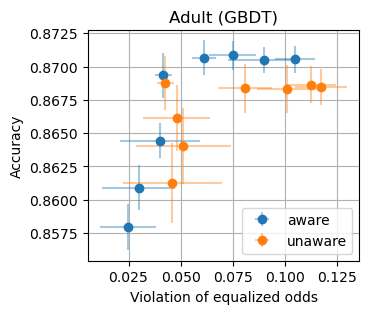

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.104615  0.009519
0.100  0.870502  0.000984  0.089933  0.017383
0.080  0.870830  0.001105  0.074900  0.011276
0.060  0.870652  0.001319  0.061289  0.005792
0.040  0.869342  0.001671  0.041563  0.004109
0.020  0.864442  0.001304  0.040215  0.019261
0.010  0.860920  0.001690  0.029978  0.017481
0.001  0.857958  0.001741  0.024858  0.013341

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.117159  0.012465
0.100  0.868646  0.001411  0.112457  0.012107
0.080  0.868305  0.001823  0.100711  0.014380
0.060  0.868359  0.001817  0.080870  0.012869
0.040  0.868755  0.002008  0.042682  0.003948
0.020  0.866121  0.002482  0.047997  0.015898
0.010  0.864032  0.002882  0.051144  0.022786
0.001  0.861261  0.003035  0.046041  0.023802

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Calibration (attribute-blind setting)

In [14]:
# Split pre-training data into calibration and training sets
inputs_u_train, inputs_u_calib, labels_ay_train, labels_ay_calib = sklearn.model_selection.train_test_split(
    inputs_u_pretrain,
    labels_ay_pretrain,
    test_size=split_ratio_calib,
    random_state=seed_pretrain,
)

### Logistic regression

In [15]:
# Train p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [16]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/50 [00:00<?, ?it/s]

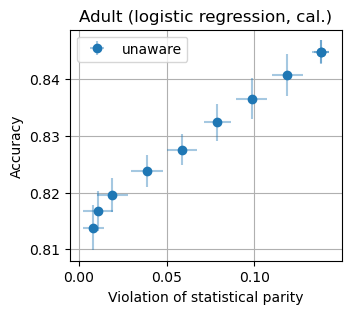

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.844854  0.002030  0.138188  0.004403
0.140  0.844799  0.002046  0.137742  0.004819
0.120  0.840773  0.003700  0.118814  0.008576
0.100  0.836596  0.003653  0.098555  0.008826
0.080  0.832405  0.003261  0.078888  0.007883
0.060  0.827573  0.002782  0.058612  0.008657
0.040  0.823751  0.002844  0.038814  0.008939
0.020  0.819560  0.002933  0.019068  0.008997
0.010  0.816790  0.003533  0.011001  0.008404
0.001  0.813787  0.003965  0.008125  0.005974

In [17]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/30 [00:00<?, ?it/s]

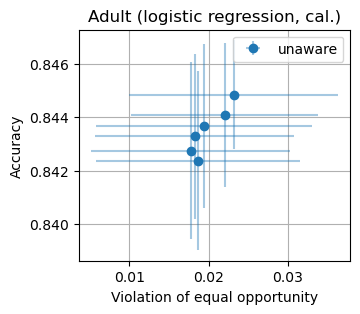

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.844854  0.002030   0.023143  0.013173
0.020  0.844103  0.002691   0.022012  0.011777
0.015  0.843680  0.003052   0.019392  0.013624
0.010  0.843284  0.003089   0.018226  0.012538
0.005  0.842752  0.003304   0.017756  0.012520
0.001  0.842383  0.003352   0.018652  0.012878

In [18]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/30 [00:00<?, ?it/s]

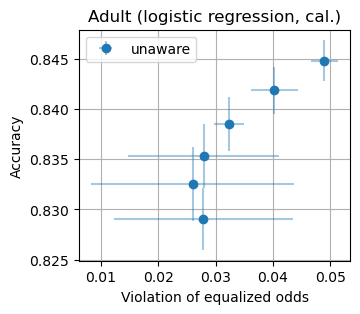

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.844854  0.002030  0.048995  0.002366
0.040  0.841878  0.002370  0.040247  0.004132
0.030  0.838534  0.002661  0.032342  0.002655
0.020  0.835326  0.003207  0.027917  0.013108
0.010  0.832542  0.003649  0.026056  0.017671
0.001  0.829047  0.003117  0.027875  0.015619

In [19]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.04, 0.03, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### Gradient boosting decision tree

In [20]:
# Train p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=-1)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [21]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/50 [00:00<?, ?it/s]

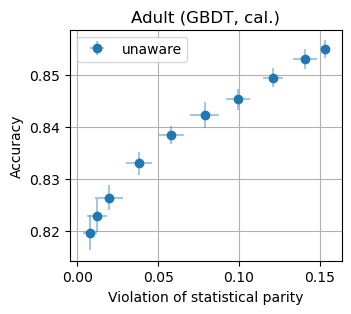

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.854955  0.001698  0.153106  0.002595
0.140  0.853085  0.001921  0.140976  0.007352
0.120  0.849454  0.001856  0.120967  0.006283
0.100  0.845291  0.002052  0.099245  0.007420
0.080  0.842274  0.002436  0.078722  0.008821
0.060  0.838425  0.001683  0.058119  0.007789
0.040  0.832978  0.002180  0.038333  0.008088
0.020  0.826385  0.002449  0.019710  0.008813
0.010  0.822918  0.003149  0.012343  0.006199
0.001  0.819656  0.003378  0.007841  0.004562

In [22]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

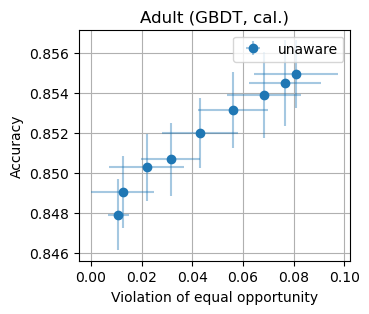

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.854955  0.001698   0.080863  0.016619
0.070  0.854491  0.002159   0.076532  0.014301
0.060  0.853904  0.002159   0.068241  0.014788
0.050  0.853153  0.001914   0.055914  0.013914
0.040  0.852007  0.001743   0.042958  0.014840
0.030  0.850696  0.001834   0.031345  0.011745
0.020  0.850287  0.001690   0.022037  0.014807
0.010  0.849044  0.001799   0.012466  0.012325
0.001  0.847912  0.001779   0.010747  0.004245

In [23]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

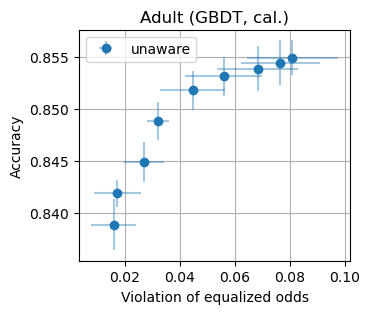

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.854955  0.001698  0.080863  0.016619
0.070  0.854491  0.002159  0.076532  0.014301
0.060  0.853904  0.002159  0.068241  0.014788
0.050  0.853153  0.001914  0.055914  0.013914
0.040  0.851802  0.001878  0.044611  0.011682
0.030  0.848867  0.001810  0.031944  0.004019
0.020  0.844868  0.001949  0.026982  0.007420
0.010  0.841851  0.001344  0.017309  0.008696
0.001  0.838848  0.002483  0.015907  0.008037

In [24]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)